# Spectral Partitioning of Bipartite Graphs

---

Typical example of bipartite graph is a graph obtained from a collection of documents presented as a _term $\times$ document_  matrix.

## Prerequisites

The reader should be familiar with k-means algorithm and spectral graph partitioning theory and algorithms.
 
## Competences 

The reader should be able to apply spectral partitioning of bipartite graphs to data clustering problems.

__Credits__: The notebook is based on [I. Mirošević, Spectral Graph Partitioning and Application to Knowledge Extraction][Mir05].

[Mir05]: #1 "I. Mirošević, 'Spectral Graph Partitioning and Application to Knowledge Extraction', M.Sc. Thesis, Iniversity of Zagreb, 2005 (in Croatian)." 

---

## Definitions

__Undirected bipartite graph__ $G$ is a triplet 
$G=(T,D,E)$, where $T=\{t_{1},\cdots ,t_{m}\}$ and 
$D=\{d_{1},...,d_{n}\}$ are two sets of vertices and
$E=\{(t_{i},d_{j}):t_{i}\in R,d_{j}\in D\}$, 
is a set of edges.

$G$ is __weighted__ if there is weight $\omega(e)$ associated with each edge $e\in E$.

For example, $D$ is a set of documents, 
$T$ is a set of terms (words) and  edge $e=(t_{i},d_{j})$ exists if
document $d_{j}$ contains term $t_{i}$. Weight $\omega(e)$ can be number of appearances 
of the term $t_i$ in the document $d_j$.

A __term-by-document-matrix__ is a matrix $A\in\mathbb{R}^{m\times n}$ with 
$A_{ij}=\omega((t_i,d_j))$.

## Facts

1. The weight matrix of $G$ is $W=\begin{bmatrix}0 & A \\ A^{T} & 0 \end{bmatrix}$.

2. The Laplacian matrix of $G$ is 
$L=\begin{bmatrix} \Delta_{1} & -A \\ -A^{T} & \Delta_{2}\end{bmatrix}$,
where $\Delta_1$ and $\Delta_2$ are diagonal matrices with elements 
$\Delta_{1,ii}=\sum\limits_{j=1}^n A_{ij}$ for $i=1,\ldots,m$, and 
$\Delta_{1,jj}=\sum\limits_{i=1}^m A_{ij}$ for $j=1,\ldots,n$.

3. The normalized Laplacian matrix of $G$ is 
$L_n=\begin{bmatrix}
I & -\Delta_{1}^{-\frac{1}{2}}A\Delta_{2}^{-\frac{1}{2}} \\
-\Delta_{2}^{-\frac{1}{2}}A^T\Delta_{1}^{-\frac{1}{2}} & I
\end{bmatrix} \equiv 
\begin{bmatrix} I & -A_n \\ -A_n^T & I \end{bmatrix}$.

4. Let $\lambda$ be an eigenvalue of $L_n$ with an eigenvector 
$w=\begin{bmatrix} u \\ v\end{bmatrix}$, where 
$u\in \mathbb{R}^{m}$ $v\in\mathbb{R}^{n}$.
Then $L_n w=\lambda w$ implies
$A_n v =(1-\lambda)u$ and $A_n^T u=(1-\lambda)v$. Vice versa, if $(u,\sigma,v)$ is a singular triplet of $A_n$, then $1-\sigma$ is an eigenvalue of $L_n$ with (non-unit) eigenvector $w=\begin{bmatrix} u \\ v\end{bmatrix}$. 

5. The second largest singular value of $A_n$ corresponds to the second smallest eigenvalue of $L_n$, and computing the former is numerically more stable. 

5. _Bipartitioning algorithm_ is the following:
    1. For given $A$ compute $A_{n}$.
    2. Compute singular vectors of $A_{n}$, $u^{[2]}$ and $v^{[2]}$, which correspond to 
    the second largest singular value, $\sigma_2(A_n)$.
    3. Assign the partitions $T=\{T_1,T_2\}$ and $D=\{D_1,D_2\}$ according to the signs of 
    $u^{[2]}$ and $v^{[2]}$. The pair $(T,D)$ is now partitioned as 
    $\{(T_1,D_1),(T_2,D_2)\}$.


6. _Recursive bipartitioning algorithm_ is the following:
    1. Compute the bipartition $\pi=\{(T_1,D_1),(T_2,D_2)\}$ of 
    $(T,D)$. Set the counter $c=2$.
    2. While $c<k$ repeat
         1. compute bipartitions of each of the subpartitions of $(T,D)$,
         2. among all $(c+1)$-subpartitions, choose the one with the smallest 
         $pcut(\pi_{c+1})$ or $ncut(\pi_{c+1})$, respectively.
    3. Set $c=c+1$
    3. Stop

7. _Multipartitioning algorithm_ is the following:
    1. For given $A$ compute $A_{n}$.
    2. Compute $k$ left and right singular vectors, $u^{[1]},\ldots,u^{[k]}$ and 
    $v^{[1]},\ldots,v^{[k]}$, which correspond to $k$ largest singular values 
    $\sigma_1\geq \cdots \geq \sigma_k$ of $A_n$.
    3. Partition the rows of matrices 
    $\Delta_{1}^{-\frac{1}{2}}\begin{bmatrix} u^{[1]} & \ldots & u^{[k]}\end{bmatrix}$
    and 
    $\Delta_{2}^{-\frac{1}{2}}\begin{bmatrix} v^{[1]} & \ldots & v^{[k]}\end{bmatrix}$
    with the k-means algorithm.

### Example - Small term-by- document matrix

In [1]:
using Graphs
using IJuliaPortrayals
using Clustering

In [2]:
# Sources, targets, and weight
dn=[6,6,6,7,7,7]
tn=[1,2,3,2,4,5]
wn=[3,1,2,3,2,3]
[dn tn wn]

6x3 Array{Int64,2}:
 6  1  3
 6  2  1
 6  3  2
 7  2  3
 7  4  2
 7  5  3

In [3]:
G = inclist(ExVertex, ExEdge{ExVertex}; is_directed=false)
for i=1:5
    add_vertex!(G, ExVertex(i,"$i"))
    attrs=attributes(G.vertices[i],G)
    attrs["label"]="Term $i"
end

for i=1:2
    add_vertex!(G, ExVertex(i+5,"$(i+5)"))
    attrs=attributes(G.vertices[i+5],G)
    attrs["label"]="Document $i"
end

for i=1:6
    add_edge!(G, vertices(G)[dn[i]], vertices(G)[tn[i]])
end
for i=1:length(G.inclist)
    for j=1:length(G.inclist[i])
        ei=G.inclist[i][j]
        attrs = attributes(ei, G)
        attrs["label"] = wn[edge_index(ei,G)]
    end
end

In [4]:
# Plot
GraphViz(to_dot(G),"fdp","svg")

IJuliaPortrayals.GraphViz("graph graphname {\n1 [\"label\"=\"Term 1\"]\n1 -- 6 [\"label\"=\"3\"]\n2 [\"label\"=\"Term 2\"]\n2 -- 6 [\"label\"=\"1\"]\n2 -- 7 [\"label\"=\"3\"]\n3 [\"label\"=\"Term 3\"]\n3 -- 6 [\"label\"=\"2\"]\n4 [\"label\"=\"Term 4\"]\n4 -- 7 [\"label\"=\"2\"]\n5 [\"label\"=\"Term 5\"]\n5 -- 7 [\"label\"=\"3\"]\n6 [\"label\"=\"Document 1\"]\n7 [\"label\"=\"Document 2\"]\n}\n","fdp","svg")

In [5]:
W=weight_matrix(G,wn)

7x7 Array{Int64,2}:
 0  0  0  0  0  3  0
 0  0  0  0  0  1  3
 0  0  0  0  0  2  0
 0  0  0  0  0  0  2
 0  0  0  0  0  0  3
 3  1  2  0  0  0  0
 0  3  0  2  3  0  0

In [6]:
A=W[1:5,6:7]
Δ1=sqrt(sum(A,2))
Δ2=sqrt(sum(A,1))
An=map(Float64,[A[i,j]/(Δ1[i]*Δ2[j]) for i=1:size(A,1), j=1:size(A,2)])

5x2 Array{Float64,2}:
 0.707107  0.0     
 0.204124  0.53033 
 0.57735   0.0     
 0.0       0.5     
 0.0       0.612372

In [7]:
# The partitioning - explain the results!
U,σ,V=svd(An)

(
5x2 Array{Float64,2}:
 -0.46291    0.604743
 -0.534522  -0.218218
 -0.377964   0.493771
 -0.377964  -0.370328
 -0.46291   -0.453557,

[0.9999999999999999,0.8838834764831844],
2x2 Array{Float64,2}:
 -0.654654   0.755929
 -0.755929  -0.654654)

### Example - Sets of points

In [9]:
using Gadfly
using Images

In [10]:
?sprand

search: sprand sprandn sprandbool StepRange sparse2adjacencylist



```rst
..  sprand([rng,] m,n,p [,rfn])

Create a random ``m`` by ``n`` sparse matrix, in which the probability of any
element being nonzero is independently given by ``p`` (and hence the mean
density of nonzeros is also exactly ``p``). Nonzero values are sampled from
the distribution specified by ``rfn``. The uniform distribution is used in
case ``rfn`` is not specified. The optional ``rng`` argument specifies a
random number generator, see :ref:`Random Numbers <random-numbers>`.
```


In [11]:
# Define sizes
m=[200,100,100]
n=[100,200,100]
density=[0.5,0.7,0.4]
A=Array(Any,3)
for i=1:3
    A[i]=sprand(m[i],n[i],density[i])
end
B=blkdiag(A[1],A[2],A[3])

400x400 sparse matrix with 27884 Float64 entries:
	[1  ,   1]  =  0.185978
	[2  ,   1]  =  0.930463
	[3  ,   1]  =  0.951578
	[6  ,   1]  =  0.288271
	[8  ,   1]  =  0.144443
	[9  ,   1]  =  0.698419
	[12 ,   1]  =  0.975249
	[13 ,   1]  =  0.429804
	[14 ,   1]  =  0.589122
	[15 ,   1]  =  0.525998
	⋮
	[374, 400]  =  0.147314
	[381, 400]  =  0.387642
	[388, 400]  =  0.777484
	[389, 400]  =  0.0377414
	[390, 400]  =  0.64925
	[393, 400]  =  0.423817
	[395, 400]  =  0.67256
	[396, 400]  =  0.38278
	[398, 400]  =  0.172354
	[399, 400]  =  0.231409
	[400, 400]  =  0.252861

In [12]:
pB=spy(B)
draw(Gadfly.PNG("files/pB.png", 4inch, 4inch), pB)

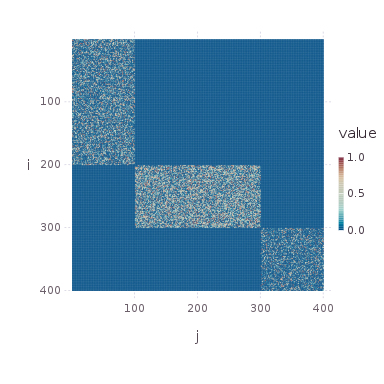

In [13]:
using Images
load("files/pB.png")

In [14]:
# The structure of singular vectors reflects the blocks
U,σ,V=svds(B,nsv=3)

(
400x3 Array{Float64,2}:
  1.77862e-17  -0.0640713     3.92523e-17
  1.69812e-17  -0.0656449     4.41589e-17
  1.93962e-17  -0.0870069    -1.47196e-17
  1.03881e-17  -0.0726003    -1.47196e-17
  2.7331e-17   -0.0776765    -1.47196e-17
  5.55819e-18  -0.0848381     3.43458e-17
  9.27643e-18  -0.0723616     4.41589e-17
  1.18064e-17  -0.0901929     7.35981e-17
  1.80162e-17  -0.0695351     1.47196e-17
  5.0982e-18   -0.0772642    -9.81308e-18
  2.15811e-17  -0.0681972    -4.41589e-17
  1.69812e-17  -0.0909592     2.94392e-17
  9.96641e-18  -0.0593217     5.39719e-17
  ⋮                                      
  3.73935e-18  -2.10951e-17   0.107678   
 -6.26427e-18   1.21866e-17   0.0804496  
 -1.97112e-18   2.82258e-17   0.0903584  
  1.04074e-18   5.58104e-17   0.087246   
  2.17761e-18   2.50479e-17   0.08859    
  8.28637e-19   4.1659e-17    0.102919   
  4.63162e-18   7.16409e-17   0.0829699  
  3.73531e-18   2.22698e-18   0.126084   
 -1.45603e-18   5.07905e-17   0.105305   
 -4.5660

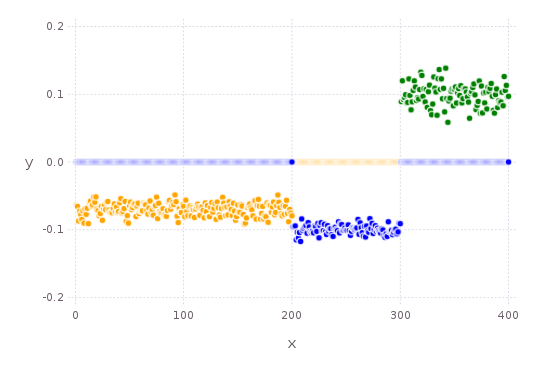

In [15]:
# Plot the first three left singular vectors
k=size(B,1)
x=collect(1:k)
Gadfly.plot(layer(x=x,y=U[:,1],Geom.point,Theme(default_color=colorant"blue")),
layer(x=x,y=U[:,2], Geom.point,Theme(default_color=colorant"orange")),
layer(x=x,y=U[:,3], Geom.point,Theme(default_color=colorant"green")))

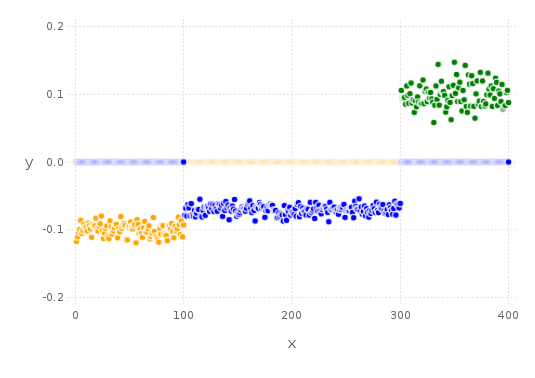

In [16]:
# Plot the first three right singular vectors
Gadfly.plot(layer(x=x,y=V[:,1],Geom.point,Theme(default_color=colorant"blue")),
layer(x=x,y=V[:,2], Geom.point,Theme(default_color=colorant"orange")),
layer(x=x,y=V[:,3], Geom.point,Theme(default_color=colorant"green")))

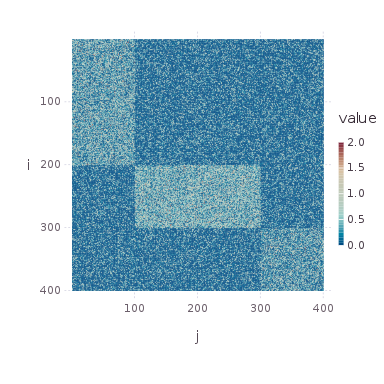

In [17]:
# Add random noise
noise=sprand(k,k,0.3)
C=B+noise
pC=spy(C)
draw(Gadfly.PNG("files/pC.png", 4inch, 4inch), pC)
load("files/pC.png")

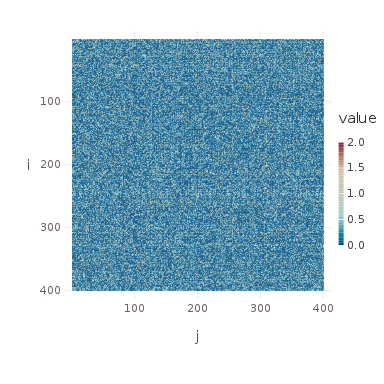

In [18]:
# Apply random permutation to rows and columns of C
D=C[randperm(k),randperm(k)]
pD=spy(D)
draw(Gadfly.PNG("files/pD.png", 4inch, 4inch), pD)
load("files/pD.png")

In [19]:
# Given D, can we recover C with spectral partitioning?
U,σ,V=svds(D,nsv=3)

(
400x3 Array{Float64,2}:
 -0.0461542  -0.0417776    0.0192639 
 -0.0456713  -0.0498393    0.0376449 
 -0.0413298  -0.0449522    0.0280559 
 -0.0636116   0.0734009    0.00794167
 -0.0710171   0.0720333    0.00821326
 -0.0638242   0.068111     0.0250511 
 -0.0419511  -0.0357578    0.0260137 
 -0.0403812  -0.0319938   -0.105762  
 -0.0494997  -0.0767571    0.0404917 
 -0.0479923  -0.0360301    0.013715  
 -0.0679837   0.0646284    0.0226709 
 -0.0446832  -0.0480517    0.0435775 
 -0.0473182  -0.057036     0.0437562 
  ⋮                                  
 -0.0395873  -0.0202009   -0.0966264 
 -0.0421794  -0.00977905  -0.0781569 
 -0.044084   -0.0446987    0.0156368 
 -0.0434713  -0.0503169    0.0339073 
 -0.0405218  -0.0164256   -0.0832686 
 -0.0395533  -0.0218991    0.010399  
 -0.0702424   0.0648613    0.0264853 
 -0.070037    0.0689225    0.0138272 
 -0.0469718  -0.0518813    0.0476648 
 -0.0360289  -0.0188509   -0.0844173 
 -0.0717576   0.07616      0.0138428 
 -0.0710651   0.0680696 

In [20]:
# Kmeans on rows and U and V
using Clustering

In [21]:
outU=kmeans(U',3)

Clustering.KmeansResult{Float64}(3x3 Array{Float64,2}:
 -0.038058   -0.0686002  -0.0435945
 -0.0142882   0.0696828  -0.0483921
 -0.0882487   0.0172062   0.0249332,[3,3,3,2,2,2,3,1,3,3  …  3,3,1,3,2,2,3,1,2,2],[8.24435e-5,0.000167994,2.67124e-5,0.000124542,9.2239e-5,8.68229e-5,0.000163492,0.000625606,0.00108152,0.000298007  …  0.000100304,8.42535e-5,3.544e-5,0.000929452,0.000112046,1.40603e-5,0.000540306,3.9615e-5,6.32358e-5,0.000113242],[100,100,200],[100.0,100.0,200.0],0.09739978763062246,2,true)

In [22]:
outV=kmeans(V',3)

Clustering.KmeansResult{Float64}(3x3 Array{Float64,2}:
 -0.0540085  -0.052034   -0.0375294
  0.0431794  -0.0742751  -0.0217079
  0.0112421   0.0389556  -0.0865216,[1,1,1,1,1,1,2,3,1,2  …  1,1,1,3,1,1,1,3,3,1],[0.000269005,0.000588363,9.93988e-5,0.000417436,0.0001847,0.000295718,3.44561e-6,0.000776535,0.000136287,4.57331e-5  …  5.3461e-5,0.000175483,0.000185792,0.000408272,0.000310371,0.000304661,0.000387151,0.000171202,8.26307e-5,0.000355708],[200,100,100],[200.0,100.0,100.0],0.10769320911628619,2,true)

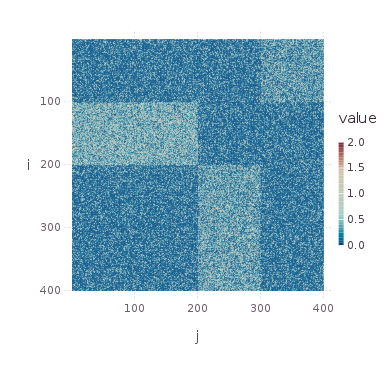

In [23]:
E=D[sortperm(outU.assignments),sortperm(outV.assignments)]
pE=spy(E)
draw(Gadfly.PNG("files/pE.png", 4inch, 4inch), pE)
load("files/pE.png")